# Task 2 - Exploratory Data Analysis (EDA)

Importing Libraries and Loading data

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
import os
sys.path.insert(0, os.path.abspath('..'))  # so we can import src/

sns.set_theme(style="whitegrid")


In [18]:

%load_ext autoreload
%autoreload 2

from src.eda_utils import (
    load_data,
    overview,
    missing_and_duplicates,
    plot_numeric,
    plot_categorical,
    correlation,
    detect_outliers
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Load data 
df = load_data("../data/raw/data.csv")
df.head()

 Loaded 95,662 rows × 16 columns


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


1. Overview of the Data

In [15]:
# Data Overview
overview(df)

=== Shape ===
95,662 rows × 16 columns

=== Data Types ===
object                 10
int64                   4
float64                 1
datetime64[ns, UTC]     1
Name: count, dtype: int64

=== First 5 Rows ===
                                              0                          1  \
TransactionId               TransactionId_76871        TransactionId_73770   
BatchId                           BatchId_36123              BatchId_15642   
AccountId                        AccountId_3957             AccountId_4841   
SubscriptionId               SubscriptionId_887        SubscriptionId_3829   
CustomerId                      CustomerId_4406            CustomerId_4406   
CurrencyCode                                UGX                        UGX   
CountryCode                                 256                        256   
ProviderId                         ProviderId_6               ProviderId_4   
ProductId                          ProductId_10                ProductId_6   
ProductCa

2. Summary Statistics

In [ ]:
# summary
print("=== Numerical Features Summary ===")
numerical_cols = ['Amount', 'Value']
display(df[numerical_cols].describe().T)


=== Numerical Features Summary ===


,count,mean,std,min,25%,50%,75%,max
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0
Value,95662.0,9900.583941,123122.087776,2.0,275.0,1000.0,5000.0,9880000.0


In [10]:
print("\n=== Categorical & Datetime Summary ===")

# TransactionStartTime parsing
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')
print(f"TransactionStartTime range: {df['TransactionStartTime'].min()} → {df['TransactionStartTime'].max()}")
print(f"Unique Customers: {df['CustomerId'].nunique():,}")
print(f"Unique Accounts: {df['AccountId'].nunique():,}")


=== Categorical & Datetime Summary ===
TransactionStartTime range: 2018-11-15 02:18:49+00:00 → 2019-02-13 10:01:28+00:00
Unique Customers: 3,742
Unique Accounts: 3,633


3. Distribution of Numerical Features

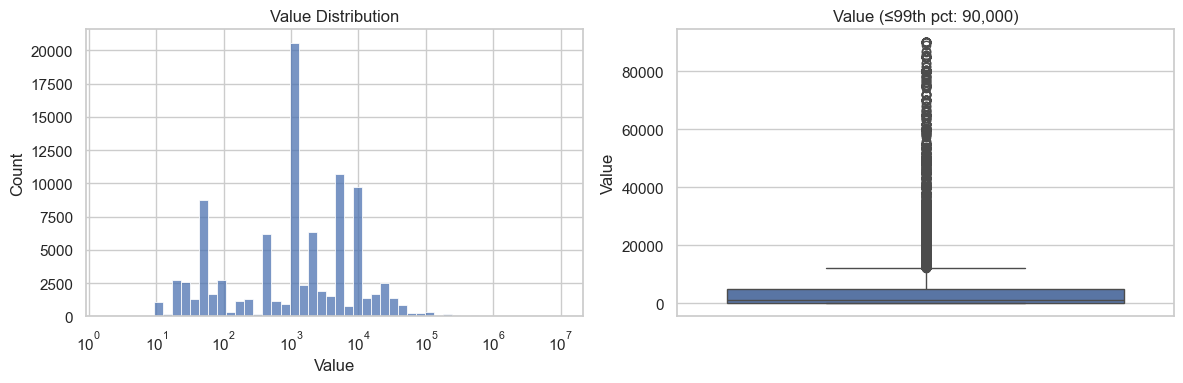

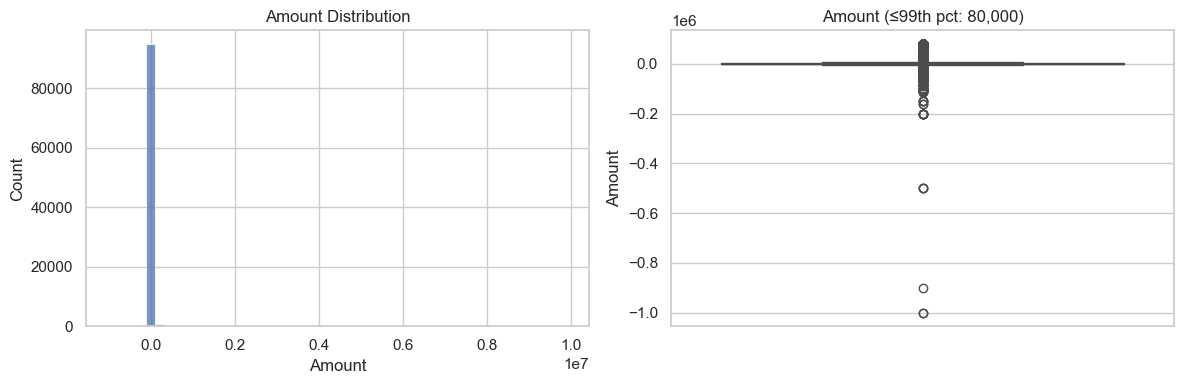

In [13]:
# Numerical Distributions
plot_numeric(df, 'Value', log_scale=True)
plot_numeric(df, 'Amount')

4. Distribution of Categorical Features

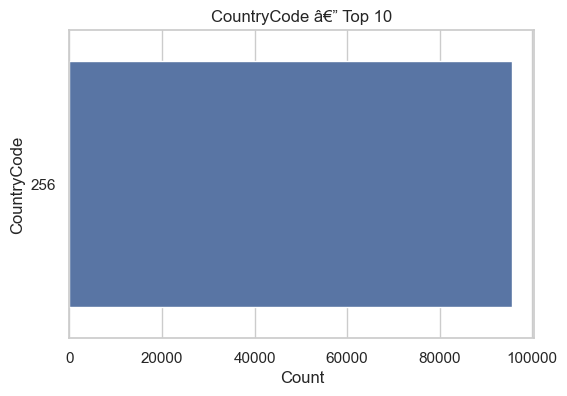

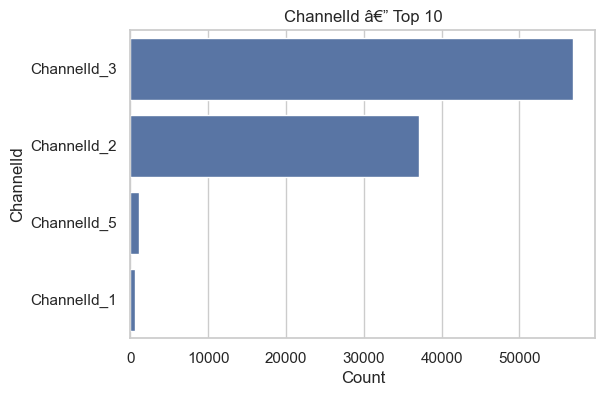

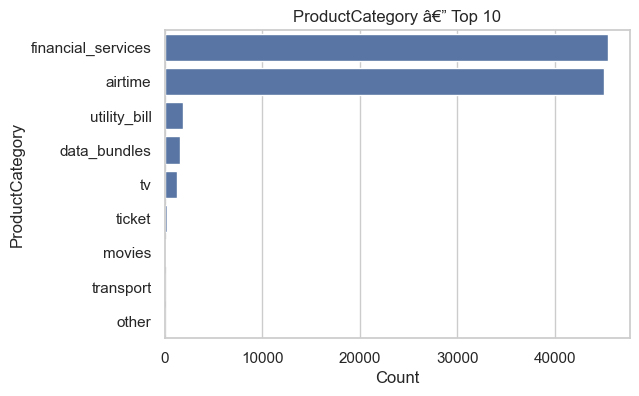

In [26]:
# Categorical Distributions
for col in ['CountryCode', 'ChannelId', 'ProductCategory']:
    plot_categorical(df, col)

5. Correlation Analysis (Numerical + Aggregated User-Level)

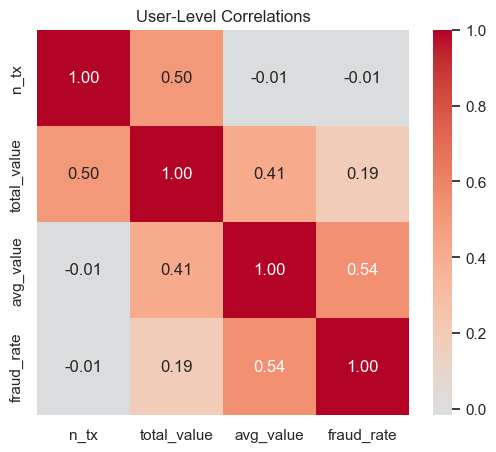

In [14]:
 ## Correlation (User-Level)
user_agg = correlation(df)


6. Identifying Missing Values

In [16]:
# 2. Data Quality
missing_and_duplicates(df)

=== Missing Values ===
No missing values.

=== Duplicates ===
Duplicate rows: 0
Duplicate TransactionId: 0


7. Outlier Detection (Boxplots for Key Numerical Features)


Outliers in 'Value' > 99.9th pct (1,000,000):
   â†’ 81 records (0.08%)
   â†’ Top 5:


,TransactionId,CustomerId,Value,ProductCategory,CountryCode
87487,TransactionId_31461,CustomerId_1535,9880000,financial_services,256
87465,TransactionId_27985,CustomerId_1535,9870000,financial_services,256
92152,TransactionId_15293,CustomerId_1535,9860888,financial_services,256
87466,TransactionId_55014,CustomerId_1535,9856000,financial_services,256
93003,TransactionId_137519,CustomerId_1535,9850000,financial_services,256


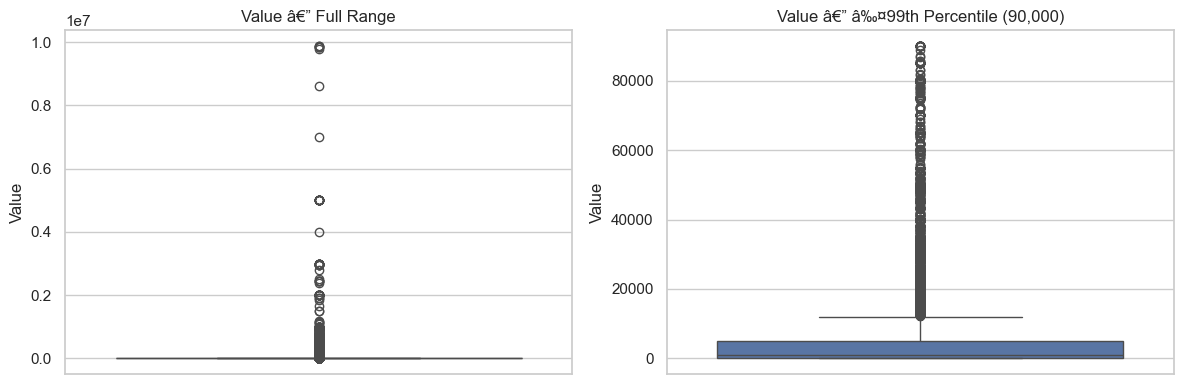

In [20]:
# Detect extreme high-value outliers
outliers = detect_outliers(df, 'Value', threshold_pct=0.999)  # top 0.1%

Top 5 EDA Insights

**1. Extreme Right-Skew in Transaction Values**
Median transaction value is $1,000, but the 75th percentile jumps to $5,000, and the maximum reaches $9.88M.
The top 0.1% of transactions (> $1M) — 81 records — are dominated by financial_services and airtime in CountryCode=256 (Uganda).

**2. Very Low Fraud Incidence**
Fraud rate is only ~0.6% (based on FraudResult), indicating a generally clean dataset.
However, high-value fraud cases exist (e.g., $5M transaction flagged as fraud), suggesting fraud correlates with extreme values.


**3. Strong Geographic and Product Concentration**
While your data contains multiple country codes, the extreme-value outliers and high-volume activity cluster in CountryCode=256 (Uganda).
ProductCategory = "financial_services" and "airtime" dominate high-value transactions.


**4. High User Transaction Frequency with Low Unique-to-Account Ratio**
3,742 unique customers vs. 3,633 unique accounts → many users have multiple accounts (e.g., shared devices/families).
Mean transactions per user ≈ 25.6, indicating rich behavioral history for RFM modeling.

**5. No Missing Data or Duplicates **
Zero missing values and zero duplicate TransactionIds or rows — High-Quality Raw Dataset.